In [15]:
%load_ext autoreload
from mps.state import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TIME EVOLUTION

In [16]:
# file: mps/evolution.py

import numpy as np
import scipy.linalg
from mps.state import _truncate_vector

Some of the commonly used operators:

In [17]:
# file: mps/evolution.py

σz = np.diag([1.0,-1.0])
i2 = np.identity(2)
σx = np.array([[0, 1], [1, 0]])
σy = -1j * σz @ σx

def creation_op(d):
    # Returns d dimensional cration operator
    return np.diag(np.sqrt(np.arange(1,d)),-1).astype(complex)

def annihilation_op(d):
    # Returns d dimensional cration operator
    return np.diag(np.sqrt(np.arange(1,d)),1).astype(complex)



## Nearest Neighbor Hamiltonians

Below is the interface we use for nearest neighbor interaction Hamiltonians. It is initially empty.

In [18]:
# file: mps/evolution.py

class NNHamiltonian(object):
    
    def __init__(self, size):
        #
        # Create a nearest-neighbor interaction Hamiltonian
        # of a given size, initially empty.
        #
        self.size = size
        
    def dimension(self, ndx, t=0.0):
        #
        # Return the dimension of the local Hilbert space
        #
        return 0
    
    def interaction_term(self, ndx, t=0.0):
        #
        # Return the interaction between sites (ndx,ndx+1)
        #
        return 0

Generally, we can have different local terms and different interactions on every site
$$
H = \sum_i \left[O_i + \sum_n L^{(n)}_i \otimes R^{(n)}_{i+1}\right]_\text{site i} 
=  \sum_{i=0}^{N-2} h_{i,i+1}. 
$$
where
$$
h_{i,i+1} = \sum_n L^{(n)}_i \otimes R^{(n)}_{i+1} +
\begin{cases}
O_i + \frac{1}{2} O_{i+1}, \text{ if  } i = 0 \\
\frac{1}{2} O_i + O_{i+1}, \text{ if  } i = N-2 \\
\frac{1}{2} O_i + \frac{1}{2} O_{i+1}, \text{ else  } 
\end{cases}
$$
and $N>2$.

The function below computes the interaction terms $h_{i,i+1}$:

In [19]:
# file: mps/evolution.py

def _compute_interaction_term(H, ndx, t=0.0):
    """Computes the interaction term between site ndx and ndx+1, including the local terms 
    for the two sites
    
    Arguments:
    H = NNHamiltonian
    ndx = site index
    """
    if isinstance(H.local_terms[ndx], np.ndarray ):            
        if ndx == 0:
            H.interactions[ndx] +=  np.kron(H.local_terms[ndx],
                                               np.eye(H.dimension(ndx+1)))
        else:
            H.interactions[ndx] +=  0.5 * np.kron(H.local_terms[ndx],
                                                     np.eye(H.dimension(ndx+1)))
    if isinstance(H.local_terms[ndx+1], np.ndarray ):            
        if ndx == H.size-2:
            H.interactions[ndx] +=  np.kron(np.eye(H.dimension(ndx)),
                                               H.local_terms[ndx+1])
        else:
            H.interactions[ndx] +=  0.5 * np.kron(np.eye(H.dimension(ndx)),
                                                     H.local_terms[ndx+1])

    return H.interactions[ndx]

In [20]:
# file: mps/evolution.py

class ConstantNNHamiltonian(NNHamiltonian):
    
    def __init__(self, size):
        #
        # Create a nearest-neighbor interaction Hamiltonian with fixed
        # local terms and interactions.
        #
        #  - local_term: operators acting on each site (can be different for each site)
        #  - int_left, int_right: list of L and R operators (can be different for each site)
        #
        self.size = size
        self.local_terms = [0] * size
        self.int_left = [[]] * (size-1)
        self.int_right = [[]] * (size-1)
        self.interactions = [0] * (size-1)

    def set_local_term(self, ndx, operator):
        #
        # Set the local term acting on the given site
        #
        self.local_terms[ndx] = operator

    def add_interaction_term(self, ndx, L, R):
        #
        # Add an interaction term $L \otimes R$ acting on sites 'ndx' and 'ndx+1'
        #
        # Add to int_left, int_right
        #
        # Update the self.interactions[ndx] term
        self.int_left[ndx].append(L)
        self.int_right[ndx].append(R)
        self.interactions[ndx] += np.kron(L,R)
        
    def dimension(self, ndx, t=0.0):
        #
        # Return the dimension of the local Hilbert space
        #
        if ndx == self.size -1:
            return self.int_right[ndx-1][0].shape[0]
        else:
            return self.int_left[ndx][0].shape[0]
    
    #def interaction_term(self, ndx, t=0.0):
        #
        # Return the interaction between sites (ndx,ndx+1) including the corresponding local terms.
        #
        #return _compute_interaction_term(self, ndx, t=0.0)

A particular case would be a translationally invariant, constant Hamiltonian
$$H = \sum_i \left[O + \sum_n L^{(n)} \otimes R^{(n)}\right]_\text{site i}$$
which has the same local term $O$ on all sites, and the same interaction given by the product of $L^{(n)}$ left and $R^{(n)}$ right operators.

In [21]:
# file: mps/evolution.py

class TINNHamiltonian(ConstantNNHamiltonian):
    
    def __init__(self, size, local_term, intL, intR):
        #
        # Create a constant nearest-neighbor interaction Hamiltonian with fixed
        # local terms and interactions.
        #
        #  - local_term: operator acting on every site
        #  - int_left: list of L (applied to site ndx) operators
        #  - int_right: list of R (applied to site ndx + 1) operators
        #  - interaction: kronecker product of corresponding L and R pairs
        #
        self.size = size
        self.local_terms = [local_term] * size
        self.int_left = [[]] * (size-1)
        self.int_right = [[]] * (size-1)
        self.intL = intL
        self.intR = intR
        self.interactions = [0] * (size-1)
    
    def interaction_term(self, ndx, t=0.0):
        #
        # Return the interaction between sites (ndx,ndx+1)
        #
        if isinstance(self.interactions[ndx], np.ndarray):
            return self.interactions[ndx]
        
        else:
            for L,R in zip(self.intL, self.intR):
                self.add_interaction_term(ndx, L, R)
               
            return _compute_interaction_term(self, ndx, t=0.0)
        

## Suzuki-Trotter Decomposition

In Suzuki-Trotter decomposition, the Hamiltonians of the nearest neighbor couplings can be decomposed into two non-commuting parts, $H_{\text{odd}} $ and $ H_{\text{even}} $, so that all additive 2-site operators in each part commute with each other.

Let us consider a simple example of tight binding model with on-site potential and decompose the Hamiltonian into 2-site terms, so that $H=\sum_i h_{i,i+1}$. 
\begin{equation}
h_{i,i+1} = \left(\frac{\omega}{2}  a_i^\dagger a_i \right) + \left(\frac{\omega}{2}  a_{i+1}^\dagger a_{i+1} \right) - \left( t a_{i}^\dagger a_{i+1} + \text{h.c.} \right).
\end{equation}
Since $[h_{i,i+1},h_{i+2,i+3}] = 0$, we can group these terms for even and odd $i$, so that $H = H_{\text{odd}} + H_{\text{even}} $. 

Note that the local term $ a_i^\dagger a_i$ appears only in one the groups for $i=1$ and $i=N$. Therefore we need to add two on-site terms $h_1 = \left(\frac{\omega}{2}  a_1^\dagger a_1 \right) $ and $h_N = \left(\frac{\omega}{2}  a_N^\dagger a_N \right) $, to the corresponding two-site terms. So that $h_{1,2} \rightarrow h_{1,2} + h_1$, and $h_{N-1,N} \rightarrow h_{N-1,N} + h_N$.

And for the first order Suzuki-Trotter decomposition, the evolution operator becomes
\begin{equation}
e^{-i \hat{H} \Delta t} = e^{-i \hat{H}_{\text{odd}} \Delta t}  e^{-i \hat{H}_{\text{even}} \Delta t} + O(\Delta t^2).
\end{equation}

The class Trotter_unitaries creates a list of Trotter unitarities corresponding to two-site operators, $U_{i,i+1} = e^{-i h_{i,i+1} \Delta t}$. The Trotter unitarities associated with $\hat{H}_{\text{odd}}$ and $\hat{H}_{\text{even}}$ are applied separately in consecutive sweeps depending on evenodd value passed to TEBD_sweep class. 

If evenodd = 0:
$$ U_{\text{odds}} = [U_{1,2}, U_{3,4}, \dots ], $$
and if evenodd = 1:
$$ U_{\text{evens}} = [U_{2,3}, U_{4,5}, \dots ], $$


In [22]:
# file: mps/evolution.py

class Trotter_unitaries(object):
    """"Create Trotter unitarities from a nearest-neighbor interaction Hamiltonian.
        
    Attributes:
    H = NNHamiltonian
    δt = Time step
    """

    def __init__(self, H, δt):
        self.H = H
        self.δt = δt
                
    def twosite_unitary(self, start):
        """Creates twp-site exponentials from interaction H terms"""
        U = scipy.linalg.expm(-1j * self.δt * self.H.interaction_term(start))
        U = U.reshape(self.H.dimension(start),self.H.dimension(start+1),
                      self.H.dimension(start),self.H.dimension(start+1))
        return U
    
    

We apply each $U_{i,i+1} = e^{-i h_{i,i+1} \Delta t}$ to two neighbouring tensors, $A_i$ and $A_{i+1}$ simultaneously, as shown below.

<img src="fig_pdf/apply_mpo_to2site.svg" style="max-width: 90%; width: 35em">

The resulting tensor $B$ is a two-site tensor. We split this tensor into two one-site tensors using left_orth_2site and right_orth_2site functions, which are defined in [this notebook](File%201c%20-%20Canonical%20form.ipynb). 

In [23]:
# file: mps/evolution.py

def apply_2siteTrotter(U, ψ, start):
    return np.einsum('ijk,klm,prjl -> iprm', ψ[start],
                     ψ[start+1], U)


In [24]:
# file: mps/evolution.py

def TEBD_sweep(H, ψ, δt, dr, evenodd, tol=0):
    #
    # Apply a TEBD sweep by evolving with the pairwise Trotter Hamiltonian
    # starting from left/rightmost site and moving on the 'direction' (>0 right,
    # <0 left) by pairs of sites.
    #
    # - H: NNHamiltonian
    # - ψ: Initial state in CanonicalMPS form (modified destructively)
    # - δt: Time step
    # - evenodd: 0, 1 depending on Trotter step
    # - direction: where to move
    #
    Trotter = Trotter_unitaries(H, δt)        
    def update_two_site(start, nextsite, dr):
        # Apply combined local and interaction exponential and move
        ψ.center = ψ.center + dr
        if start == 0:
            dr = +1
        elif start == (ψ.size-2):
            dr = -1
        AA = apply_2siteTrotter(Trotter.twosite_unitary(start) , ψ, start)
        ψ.update_canonical_2site(AA, start, nextsite, dr, tolerance=tol)

    #
    # Loop over ψ, updating pairs of sites acting with the unitary operator
    # made of the interaction and 0.5 times the local terms
    #
    if dr < 0:
        if ψ.size%2 == evenodd:
            start = ψ.size -1
        else:
            start = ψ.size -2
        for j in range(start, 0, -2):
            update_two_site(j-1, j, dr)
    else:
        start = 0 + evenodd
        for j in range(start, ψ.size-1, +2):
            update_two_site(j, j+1, dr)        
            
    return ψ



## Error in Suzuki-Trotter decomposition

In the first order Suzuki-Trotter decomposition, evolution operator becomes
\begin{equation}
e^{-i \hat{H} \Delta t} = e^{-i \hat{H}_{\text{odd}} \Delta t}  e^{-i \hat{H}_{\text{even}} \Delta t} + O(\Delta t^2).
\end{equation}
Note that after $T/\Delta t$ time steps, the accumulated error is in the order of $\Delta t$.
Higher order Suzuki-Trotter decompositions can be used to reduce error.




# Tests

In [25]:
# file: mps/test/test_TEBD.py
import unittest
import mps.state
import mps.tools
from mps.evolution import *
from mps.test.tools import *
import scipy.sparse as sp


        
def random_wavefunction(n):
    ψ = np.random.rand(n) - 0.5
    return ψ / np.linalg.norm(ψ)

class TestTEBD_sweep(unittest.TestCase):
    
    def test_orthonormalization(self):
        #
        # We verify that our two-site orthonormalization procedure, 
        # does not change the state
        #
        δt = 0.1

        def ok(Ψ):
            H = TINNHamiltonian(Ψ.size, 0*σx, [mps.tools.random_Pauli()], [mps.tools.random_Pauli()])
            Trotter = Trotter_unitaries(H, δt)
            for start in range(Ψ.size-2):
                AA = apply_2siteTrotter(Trotter.twosite_unitary(start) , 
                                                      Ψ, start)
                A, AC = mps.state.left_orth_2site(AA, DEFAULT_TOLERANCE)
                AA_orth = np.einsum("ijk,klm -> ijlm", A, AC)
                self.assertTrue(similar(AA,AA_orth))    
                
                AA = apply_2siteTrotter(Trotter.twosite_unitary(start) , 
                                                      Ψ, start)
                A, AC = mps.state.right_orth_2site(AA, DEFAULT_TOLERANCE)
                AA_orth = np.einsum("ijk,klm -> ijlm", AC, A)
                self.assertTrue(similar(AA,AA_orth))
            
            
        test_over_random_mps(ok)
        
    def test_right_sweep(self):
        #
        # We verify the truncation procedure does not change the resulting state. 
        # We evolve the mps only through one sweep to eliminate the error due to 
        # non-commuting terms in the Hamiltonian. We compare the TEBD results with 
        # exact diagonalization results.
        #
        # Note that there is a phase difference between the two wavefunctions.
        # However absolute values of the corresponding coefficients are equal 
        # as the test verifies.
        #             
        N = 6
        t = 1
        ω = 0.5
        dt = 1
        ψwave = random_wavefunction(N)
        ψmps = CanonicalMPS(mps.state.wavepacket(ψwave), center=0)
        # We use the tight-binding Hamiltonian
        # Test for evenodd = 0      
        H=TINNHamiltonian(N, ω*creation_op(2)@ annihilation_op(2), 
                            [t * annihilation_op(2) , t * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)])
        ψmps_final = TEBD_sweep(H, ψmps, dt, 1, 0, tol=DEFAULT_TOLERANCE)
        Hmat = sp.diags([[t,0]*(N//2), [ω]+[ω/2]*(N-2)+[ω], [t,0]*(N//2)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        ψwave_final = sp.linalg.expm_multiply(-1j * dt * Hmat, ψwave)
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψmps_final.tovector())))
        
        # Test for evenodd = 1      
        ψmps = CanonicalMPS(mps.state.wavepacket(ψwave), center=1)
        ψmps_final = TEBD_sweep(H, ψmps, dt, 1, 1, tol=DEFAULT_TOLERANCE)
        Hmat = sp.diags([[0,t]*(N//2), [ω/2]*(N-1)+[ω], [0,t]*(N//2)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        ψwave_final = sp.linalg.expm_multiply(-1j * dt * Hmat, ψwave)
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψmps_final.tovector())))
     
    
    def test_left_sweep(self):
        #
        # We verify the truncation procedure does not change the resulting state. 
        # We evolve the mps only through one sweep to eliminate the error due to 
        # non-commuting terms in the Hamiltonian. We compare the TEBD results with 
        # exact diagonalization results.
        #
        # Note that there is a phase difference between the two wavefunctions.
        # However absolute values of the corresponding coefficients are equal 
        # as the test verifies.
        #       
        N = 5
        t = 0.1
        ω = 0.5
        dt = 1
        ψwave = random_wavefunction(N)
        ψmps = CanonicalMPS(mps.state.wavepacket(ψwave), center=N-2)
        # We use the tight-binding Hamiltonian
        # Test for evenodd = 0        
        H=TINNHamiltonian(N, ω*creation_op(2)@ annihilation_op(2), 
                            [t * annihilation_op(2) , t * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)])
        
  
        ψmps_final = TEBD_sweep(H, ψmps, dt, -1, 0, tol=DEFAULT_TOLERANCE)
        Hmat = sp.diags([[t,0]*(N//2), [ω]+[ω/2]*(N-2)+[ω], [t,0]*(N//2)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        ψwave_final = sp.linalg.expm_multiply(-1j * dt * Hmat, ψwave)
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψmps_final.tovector())))
     
        
        
    def test_TEBD_evolution(self):
        #
        #
        #
        N = 20
        t = 0.1
        ω = 0.5
        dt = 1e-5
        Nt = int(10)
        ψwave = random_wavefunction(N)
        ψmps = CanonicalMPS(mps.state.wavepacket(ψwave))
        # We use the tight-binding Hamiltonian
        H = TINNHamiltonian(N, ω*creation_op(2)@ annihilation_op(2), 
                            [t * annihilation_op(2) , t * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)])
        for i in range(Nt):
            
            ψmps = TEBD_sweep(H, ψmps, dt, 1, 0, tol=DEFAULT_TOLERANCE)
            ψmps = TEBD_sweep(H, ψmps, dt, -1, 1, tol=DEFAULT_TOLERANCE)
        
        Hmat = sp.diags([[t,0]*(N//2), ω, [t,0]*(N//2)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        ψwave_final = sp.linalg.expm_multiply(-1j * dt*Nt * Hmat, ψwave)
        
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψmps.tovector())))
                


    

In [29]:
%autoreload
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestTEBD_sweep'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_TEBD_evolution (__main__.TestTEBD_sweep) ... ok
test_left_sweep (__main__.TestTEBD_sweep) ... ok
test_orthonormalization (__main__.TestTEBD_sweep) ... ok
test_right_sweep (__main__.TestTEBD_sweep) ... ok

----------------------------------------------------------------------
Ran 4 tests in 1.129s

OK


# Error analysis

In [32]:
import mps.state
import scipy.sparse as sp
import numbers


def prepare_gaussian(xx,x0,w0,k0):
    state0 = np.exp(-(xx-x0)**2 / w0**2 + 1j * k0*xx)
    return state0 / np.linalg.norm(state0)

def evolve(x0, w0, k0, N, Tf, sigma, γ, ω, tt):
    xx=np.arange(N)
    state0=prepare_gaussian(xx,x0,w0,k0)

    HM = sp.diags([[tt]*N, ω, [tt]*N],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
    if isinstance(Tf, numbers.Number):
        return sp.linalg.expm_multiply(-1j * Tf * HM, state0)
    else:
        return np.array([sp.linalg.expm_multiply(-1j * t * HM, state0)
                         for t in np.array(Tf)])
    
d=2
# number of sites
N=20
# on-site energy / cavity freq.
ω = np.pi
# hopping parameter t
tt = ω / 10

# time step
Nit = 10
dt = 1e-2
Tf=dt*Nit

sigma=1

x0 = N//2
w0 = N//5
k0 = np.pi/2
γ=0.5
xx=np.arange(N)

Nit = 10
Ntotal = 0.1
error_list = []

dt = 1e-3
dt_list = dt / np.array([1, 10, 100])
Nit_list = [int(Ntotal//dt) for dt in dt_list] 
overlap_list=[]

hmps = TINNHamiltonian(N, ω*creation_op(2)@ annihilation_op(2), 
                            [tt * annihilation_op(2) , tt * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)])

state0 = mps.state.gaussian(N, x0, w0, k0)

state_vec = prepare_gaussian(xx,x0,w0,k0)
for dt, Nit in zip(dt_list, Nit_list):
    print(dt)
    state_can = mps.state.CanonicalMPS(state0, 0, tolerance=1e-8)    
    state_exact = evolve(x0, w0, k0, N, dt*Nit, sigma, γ, ω, tt)
    for i in range(Nit):
        state_can = TEBD_sweep(hmps, state_can, dt, 1, 0, tol=1e-8)
        state_can = TEBD_sweep(hmps, state_can, dt, -1, 1, tol=1e-8)
    
    state_exact=state_exact/np.linalg.norm(state_exact)
    exact_mps = mps.state.wavepacket(state_exact)
    #state_can.__init__(normalize=True)
    error_list.append(np.mean(abs(mps.state.MPS(state_can[:]).all_expectation1\
                                 (creation_op(d)@annihilation_op(d))
                                 -np.abs(state_exact)**2)))
    overlap_list.append(1-abs(expectation.scprod(exact_mps,state_can)))




0.001
0.0001
1e-05


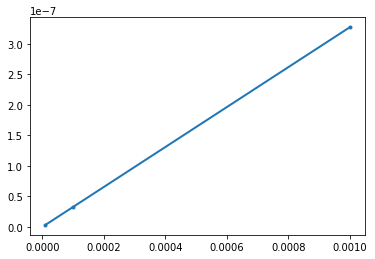

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(dt_list, error_list, ".-", linewidth=2)